<a href="https://colab.research.google.com/github/honeyd3wy/PyTorch/blob/master/n223-evaluation-metrics-for-classification/n223a-evaluation-metrics-for-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **다음 조건에서 F beta score를 구하고 과제 제출폼에 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다.

In [1]:
TP = 4442
TN = 6165
FP = 1515
FN = 1930
beta = 2

In [2]:
def my_fbeta_score(precision, recall, beta=1.0):
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

In [3]:
# precision: Positive 정답률
p = TP / (TP + FP)

# recall: True 정답률
r = TP / (TP + FN)

print(f'F beta score: {my_fbeta_score(p, r, beta)}')

F beta score: 0.7063126093178566


### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(객관식) 임계값을 증가시킬때 positive 범주에 대한 재현율의 변화 양상을 과제 제출폼에 제출하세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


In [4]:
# 데이터 불러오기

import pandas as pd

test_y = pd.read_csv('https://docs.google.com/uc?export=download&id=1ymZWBAzKXk0ODgY-Ljpp6vP7laHtWqKC')
test_X = pd.read_csv('https://docs.google.com/uc?export=download&id=18AtEWMCrN0suqvib_IY-BObh3tP0-ejK')
raw_train_y = pd.read_csv('https://docs.google.com/uc?export=download&id=1Qb28eBda2XUpJ98WFe7KfwH0GCMH7gUa')
raw_train_X = pd.read_csv('https://docs.google.com/uc?export=download&id=1h-hYeD1V5Tk7bmjC1ci6PxB_GmU4veiZ')

In [5]:
# 데이터 분리
from sklearn.model_selection import train_test_split

train_X, val_X = train_test_split(raw_train_X, train_size=0.80, test_size=0.20, 
                              stratify=raw_train_y, random_state=2)

train_y, val_y = train_test_split(raw_train_y, train_size=0.80, test_size=0.20, 
                              stratify=raw_train_y, random_state=2)

In [6]:
train_y = train_y.drop(columns='vacc_seas_f')
val_y = val_y.drop(columns='vacc_seas_f')

In [7]:
# Feature Engineering
import numpy as np

def engineer(df):
    
    # 예방에 대한 행동을 모두 더한 새로운 특성 생성
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['preventive_action'] = df[behaviorals].sum(axis=1)
    # 반영된 특성 제거
    dels = [col for col in df.columns if ('behavioral' in col)]
    df.drop(columns=dels, inplace=True)

    
    # '기타'항목의 비율이 너무 높고 null값의 비율이 높은 employment 관련 항목 제거
    # target에 없는 season 관련 항목 제거
    dels = [col for col in df.columns if ('health_insurance' in col or 'employment_industry' in col or 'employment_occupation' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df


train_X = engineer(train_X)
val_X = engineer(val_X)
test_X = engineer(test_X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
# pip install category_encoders

In [9]:
# pip install --upgrade git+https://github.com/scikit-learn-contrib/category_encoders

In [10]:
# 랜덤 포레스트 모델링
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline


pipe_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True, max_depth=11, min_samples_leaf=10, min_samples_split=20, n_estimators=100)
)

pipe_rf.fit(train_X, train_y)
print('훈련 정확도: ', pipe_rf.score(train_X, train_y))
print('검증 정확도: ', pipe_rf.score(val_X, val_y))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


훈련 정확도:  0.8321620259170299
검증 정확도:  0.8153243980547977


In [11]:
print('테스트 데이터 정확도: ', pipe_rf.score(test_X, test_y[['vacc_h1n1_f']]))

테스트 데이터 정확도:  0.5025619128949615


In [12]:
from sklearn.metrics import classification_report

y_pred_val = pipe_rf.predict(val_X)
print(classification_report(val_y, y_pred_val))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      6416
           1       0.67      0.45      0.54      2015

    accuracy                           0.82      8431
   macro avg       0.76      0.69      0.71      8431
weighted avg       0.80      0.82      0.80      8431



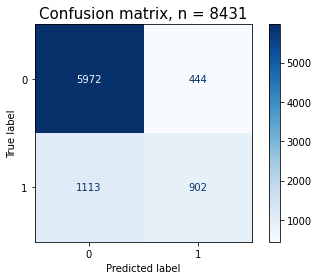

In [57]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_rf, val_X, val_y,
                            cmap=plt.cm.Blues,
                            values_format='d',
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(val_y)}', fontsize=15)
plt.show()

In [15]:
pipe_rf.predict_proba(val_X)

array([[0.91406782, 0.08593218],
       [0.93737463, 0.06262537],
       [0.38983774, 0.61016226],
       ...,
       [0.87758648, 0.12241352],
       [0.94103019, 0.05896981],
       [0.86057058, 0.13942942]])

In [16]:
# 백신접종 확률
y_pred_proba = pipe_rf.predict_proba(val_X)[:, 1]
y_pred_proba

array([0.08593218, 0.06262537, 0.61016226, ..., 0.12241352, 0.05896981,
       0.13942942])

In [17]:
from ipywidgets import interact, fixed
import seaborn as sns

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(val_y), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

임계값을 증가시키면 recall값은 **2. 감소한다.**

### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, n_estimators = n
- **(객관식) 확률값들의 분포(종류)의 변화를 과제 제출폼에 제출하세요**
    1. 다양해진다
    2. 변화가없다


In [18]:
import numpy as np

# 빈 배열 만들기
proba_list = np.empty((0, len(val_X)))

for n in [1,10,100,1000]:
    pipe2 = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(), 
        RandomForestClassifier(n_jobs=-1, random_state=10, max_depth=None, n_estimators = n)
        )
    pipe2.fit(train_X, train_y)
    y_proba = np.array([pipe2.predict_proba(val_X)[:, 1]])
    print(y_proba)
    proba_list = np.append(proba_list, y_proba, axis=0)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[[0. 0. 1. ... 1. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[[0.2 0.  0.7 ... 0.4 0.1 0.1]]


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[[0.09 0.04 0.66 ... 0.16 0.07 0.09]]


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[[0.072 0.063 0.672 ... 0.125 0.071 0.084]]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2164: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


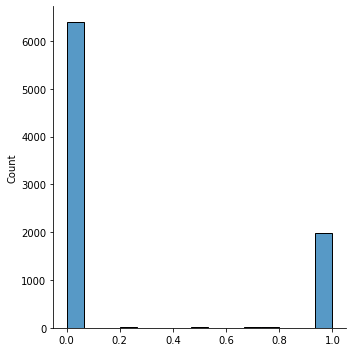

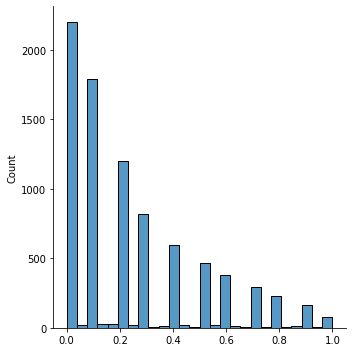

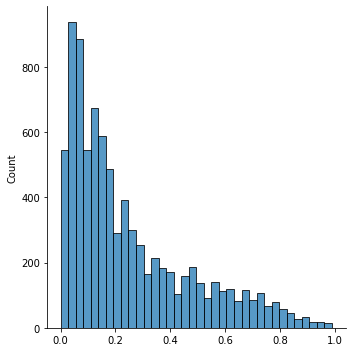

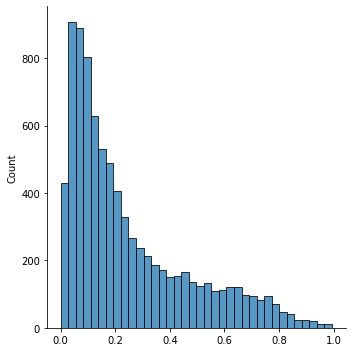

In [19]:
ax1 = sns.displot(proba_list[0], ax=[0])

ax2 = sns.displot(proba_list[1], ax=[1])

ax3 = sns.displot(proba_list[2], ax=[2])

ax4 = sns.displot(proba_list[3], ax=[3])

확률값의 분포가 다양해진다.

### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**

#### 4.1. 랜덤포레스트 모델 생성

In [30]:
# Catboost Encoding을 사용해 랜덤 포레스트 모델 학습
from category_encoders import CatBoostEncoder

pipe_rf_cb = make_pipeline(
    CatBoostEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe_rf_cb.fit(train_X, train_y)
print('훈련 정확도: ', pipe_rf_cb.score(train_X, train_y))
print('검증 정확도: ', pipe_rf_cb.score(val_X, val_y))


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


훈련 정확도:  0.8518221984995403
검증 정확도:  0.8099869529118728


In [31]:
# 최적의 하이퍼 파라미터 탐색
#from sklearn.model_selection import GridSearchCV

#params = { 'randomforestclassifier__n_estimators' : [10, 100, 1000],
#           'randomforestclassifier__max_depth' : [6, 8, 10, 12],
#           'randomforestclassifier__min_samples_leaf' : [8, 12, 18],
#           'randomforestclassifier__min_samples_split' : [8, 16, 20]
#            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
#grid_cv = GridSearchCV(pipe_rf_cb, param_grid = params, cv = 3, n_jobs = -1)
#grid_cv.fit(train_X, train_y)

#print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
#print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


최적 하이퍼 파라미터:  {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__min_samples_split': 20, 'randomforestclassifier__n_estimators': 1000}
최고 예측 정확도: 0.8159


```
최적 하이퍼 파라미터:  {'randomforestclassifier__max_depth': 12, 
'randomforestclassifier__min_samples_leaf': 8, 
'randomforestclassifier__min_samples_split': 20, 
'randomforestclassifier__n_estimators': 1000}
최고 예측 정확도: 0.8159
```

In [33]:
pipe_rf_cb = make_pipeline(
    CatBoostEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, max_depth=12, min_samples_leaf=8, min_samples_split=20, n_estimators=500, oob_score=True)
)

pipe_rf_cb.fit(train_X, train_y)
print('훈련 정확도: ', pipe_rf_cb.score(train_X, train_y))
print('검증 정확도: ', pipe_rf_cb.score(val_X, val_y))

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


훈련 정확도:  0.8262906621593571
검증 정확도:  0.8156802277309928


In [42]:
# 백신접종 확률
y_pred_proba_rf = pipe_rf_cb.predict_proba(val_X)[:, 1]
y_pred_proba_rf

array([0.11164486, 0.06008521, 0.6267491 , ..., 0.14117228, 0.06575108,
       0.17520161])

In [44]:
# 랜덤 포레스트
## ROC curve

from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(val_y, y_pred_proba_rf)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr_rf, 
    'TPRate(Recall)': tpr_rf, 
    'Threshold': thresholds_rf
})

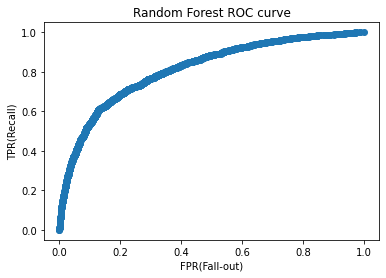

In [45]:
plt.scatter(fpr_rf, tpr_rf)
plt.title('Random Forest ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

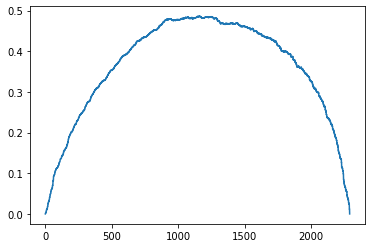

In [62]:
plt.plot(tpr_rf-fpr_rf);

In [46]:
## AUC 점수
from sklearn.metrics import roc_auc_score
auc_score_rf = roc_auc_score(val_y, y_pred_proba_rf)
auc_score_rf

0.8143430196221604

In [67]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx_rf = np.argmax(tpr_rf - fpr_rf)
optimal_threshold_rf = thresholds_rf[optimal_idx_rf]

print('idx:', optimal_idx_rf, ', threshold:', optimal_threshold_rf)

idx: 1164 , threshold: 0.2593584381377481


In [69]:
y_pred_proba_rf

array([0.11164486, 0.06008521, 0.6267491 , ..., 0.14117228, 0.06575108,
       0.17520161])

In [75]:
y_pred_opt_rf = y_pred_proba_rf >= optimal_threshold_rf
print(classification_report(val_y, y_pred_opt_rf))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      6416
           1       0.52      0.69      0.59      2015

    accuracy                           0.77      8431
   macro avg       0.70      0.74      0.72      8431
weighted avg       0.80      0.77      0.78      8431



#### 4.2. 로지스틱 회귀 모델 생성

In [34]:
# 로지스틱 회귀 모델 학습
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder

pipe_logistic = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(), 
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

pipe_logistic.fit(train_X, train_y)


print('훈련 정확도: ', pipe_logistic.score(train_X, train_y))
print('검증 정확도: ', pipe_logistic.score(val_X, val_y))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 정확도:  0.8133024938469294
검증 정확도:  0.8118847111849128


In [43]:
# 백신접종 확률
y_pred_proba_lg = pipe_logistic.predict_proba(val_X)[:, 1]
y_pred_proba_lg

array([0.09331117, 0.04163762, 0.61292179, ..., 0.15100839, 0.05458864,
       0.06496943])

In [47]:
# 로지스틱 회귀
## ROC curve

from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr_lg, tpr_lg, thresholds_lg = roc_curve(val_y, y_pred_proba_lg)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr_lg, 
    'TPRate(Recall)': tpr_lg, 
    'Threshold': thresholds_lg
})

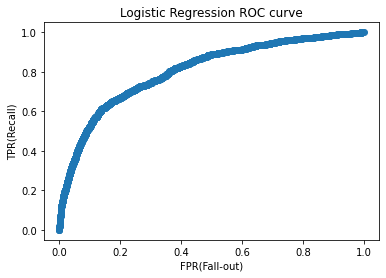

In [48]:
plt.scatter(fpr_lg, tpr_lg)
plt.title('Logistic Regression ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

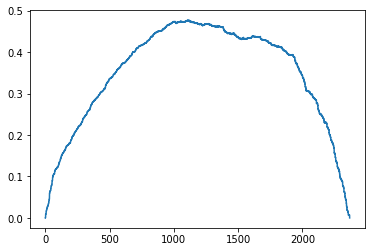

In [63]:
plt.plot(tpr_lg-fpr_lg);

In [49]:
## AUC 점수
from sklearn.metrics import roc_auc_score
auc_score_lg = roc_auc_score(val_y, y_pred_proba_lg)
auc_score_lg

0.8062037833456062

#### 4.3. 성능 평가 및 비교

1. 랜덤 포레스트 모델
2. 로지스틱 회귀 모델

두 가지의 모델을 만들었는데, ROC curve의 면적을 뜻하는 AUC점수가 1번 모델은 약 0.8143, 2번 모델은 약 0.8062로 1번이 더 높았다.

AUC값은 1이 최대값으로, 1에 가까울수록 모델의 성능이 더 좋다고 평가할 수 있다. 풀어서 설명하면, 커브가 (0,1)에 가까워질수록 커브의 경사가 급해지는데, 이는 P와 N을 판단하는 **임계점이 움직임에 따라 오답(FP)의 비율보다 정답(TP)의 비율이 빠르게 증가한다(기울기가 가파르다)**는 의미로, 모델의 성능이 좋다고 볼 수 있을 것이다.

따라서 curve의 경사가 더 급한 =  curve 아래 면적이 더 넓은 랜덤 포레스트 모델의 성능이 더 좋다고 평가한다.

In [60]:
print('랜덤 포레스트 테스트 데이터 정확도: ', pipe_rf_cb.score(test_X, test_y[['vacc_h1n1_f']]))
print('로지스틱 회귀 테스트 데이터 정확도: ', pipe_logistic.score(test_X, test_y[['vacc_h1n1_f']]))

랜덤 포레스트 테스트 데이터 정확도:  0.5032735553657842
로지스틱 회귀 테스트 데이터 정확도:  0.5020993452889269


#### 4.4. 캐글 제출 파일 생성

In [61]:
# 캐글 제출용 파일 만들기
y_pred_test = pipe_rf_cb.predict(test_X)
submission = test_y.copy()
submission['vacc_h1n1_f'] = y_pred_test
submission.to_csv('ai-05-이주연-submission-3.csv', index=False)

## 🔥 도전과제

### 5) 각 평가지표에 대해 결과를 최대한 분석하고 무엇이 부족한지, 어떤 방향으로 성능을 높여야 하는지 논하세요.

#### 5.1. 랜덤 포레스트 모델의 Confusion matrix





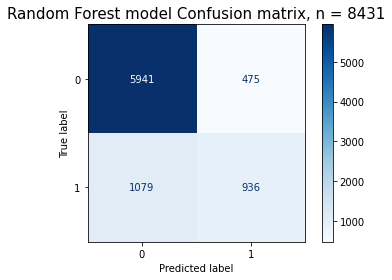

In [58]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_rf_cb, val_X, val_y,
                            cmap=plt.cm.Blues,
                            values_format='d',
                            ax=ax);
plt.title(f'Random Forest model Confusion matrix, n = {len(val_y)}', fontsize=15)
plt.show()

In [76]:
y_pred_fr = pipe_rf_cb.predict(val_X)
print(classification_report(val_y, y_pred_fr))

              precision    recall  f1-score   support

           0       0.85      0.93      0.88      6416
           1       0.66      0.46      0.55      2015

    accuracy                           0.82      8431
   macro avg       0.75      0.70      0.72      8431
weighted avg       0.80      0.82      0.80      8431



위 2번에서 threshold를 0.5에서 약 0.26으로 조정해준 report는 다음과 같다.

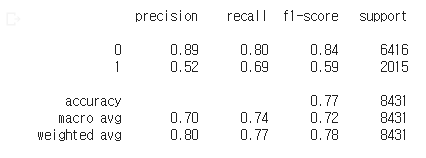



#### 5.2. 로지스틱 회귀 모델의 Confusion matrix





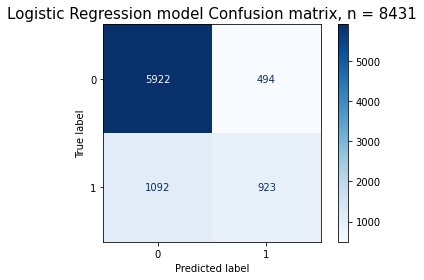

In [59]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_logistic, val_X, val_y,
                            cmap=plt.cm.Blues,
                            values_format='d',
                            ax=ax);
plt.title(f'Logistic Regression model Confusion matrix, n = {len(val_y)}', fontsize=15)
plt.show()

In [66]:
y_pred_lg = pipe_logistic.predict(val_X)
print(classification_report(val_y, y_pred_lg))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      6416
           1       0.65      0.46      0.54      2015

    accuracy                           0.81      8431
   macro avg       0.75      0.69      0.71      8431
weighted avg       0.80      0.81      0.80      8431



#### 5.3. 결론
이 모델의 목적은 사람들이 그들의 배경, 의견, 건강 행동에 대해 공유한 정보를 사용하여 **H1N1 백신을 맞았는지 예측하는 것**이다. 

백신을 접종 여부를 '왜' 예측해야 하는지 생각해보자.
> **백신 접종자를 집단 면역 목표치만큼 늘리는 것이 최종 목적**일 것이 때문이다.

이러한 경우 미접종자를 선별하기 위해 '백신을 맞지 않은 사람들을 맞지 않았다고 예측(TN)'하는 것이 중요하며, 이를 위해서는 '백신을 맞은 사람들을 맞지 않았다고 예측하는 오류(FN)'를 감안해야 하고,

'백신을 맞지 않았는데 맞았다고 예측하는 오류(FP)'는 치명적이므로 최소화 해야 할 것이다. 

> 따라서
1. 위의 모델들 중 랜덤 포레스트(threshold=0.5)의 Precision 값이 0.66으로 가장 높으므로 우리의 목적에 가장 부합하다고 할 수 있으며,
2. ***Precision을 최대화 하는 방향으로 성능을 높여야 하므로, 임계값을 더 크게 조정해야 한다.***